<a href="https://colab.research.google.com/github/MehrdadJalali-KIT/Instrument_Collaboration/blob/main/GCNMOF_800Epoch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import networkx as nx
import pandas as pd
import os
from stellargraph import StellarGraph
import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
edges_all=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/List_METAL_2000.csv')
nodes_all=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/Features_1800_NOLABEL.csv')
  
nodes_all1=pd.read_csv('/content/drive/MyDrive/MOF/MOFSMILES/Features_1800.csv')
node_subjects=nodes_all1.iloc[:,10]

G = nx.Graph()
G = StellarGraph(nodes=nodes_all,edges=edges_all)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1999, Edges: 20568

 Node types:
  default: [1999]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [20568]
        Weights: all 1 (default)
        Features: none


In [ ]:
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 1999, Edges: 20568

 Node types:
  default: [1999]
    Features: float32 vector, length 10
    Edge types: default-default->default

 Edge types:
    default-default->default: [20568]
        Weights: all 1 (default)
        Features: none


In [5]:
set(node_subjects)

{0, 1, 2, 3}

In [6]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.4, test_size=None, random_state=0,stratify=node_subjects
)

In [7]:
from collections import Counter

Counter(train_subjects)

Counter({0: 424, 1: 169, 2: 108, 3: 98})

In [8]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [9]:
batch_size = 5
num_samples = [10, 5]

In [10]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [11]:
train_gen = generator.flow(train_subjects, train_targets, shuffle=True)

In [12]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.4,
)

In [13]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [14]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
test_gen = generator.flow(test_subjects, test_targets)

In [18]:
history = model.fit(
    train_gen, epochs=800, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/800
160/160 - 3s - loss: 0.6676 - acc: 0.7747 - val_loss: 0.5661 - val_acc: 0.8642 - 3s/epoch - 20ms/step
Epoch 2/800
160/160 - 4s - loss: 0.5963 - acc: 0.8123 - val_loss: 0.5062 - val_acc: 0.8642 - 4s/epoch - 23ms/step
Epoch 3/800
160/160 - 2s - loss: 0.6104 - acc: 0.8085 - val_loss: 0.4586 - val_acc: 0.8642 - 2s/epoch - 14ms/step
Epoch 4/800
160/160 - 2s - loss: 0.6350 - acc: 0.8023 - val_loss: 0.5025 - val_acc: 0.8642 - 2s/epoch - 15ms/step
Epoch 5/800
160/160 - 3s - loss: 0.6130 - acc: 0.8073 - val_loss: 0.5552 - val_acc: 0.8642 - 3s/epoch - 16ms/step
Epoch 6/800
160/160 - 2s - loss: 0.6275 - acc: 0.8048 - val_loss: 0.4876 - val_acc: 0.8642 - 2s/epoch - 16ms/step
Epoch 7/800
160/160 - 2s - loss: 0.6162 - acc: 0.8023 - val_loss: 0.3931 - val_acc: 0.8642 - 2s/epoch - 15ms/step
Epoch 8/800
160/160 - 2s - loss: 0.5762 - acc: 0.8160 - val_loss: 0.4805 - val_acc: 0.8642 - 2s/epoch - 14ms/step
Epoch 9/800
160/160 - 4s - loss: 0.5921 - acc: 0.8135 - val_loss: 0.3772 - val_acc: 0.86

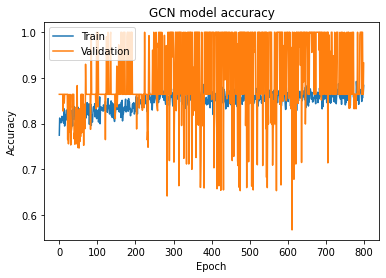

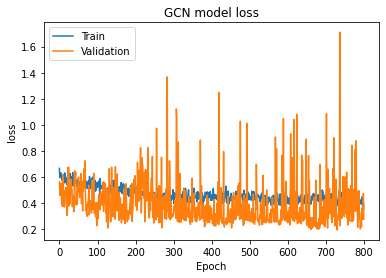

240/240 [==============================] - 2s 7ms/step - loss: 0.2776 - acc: 0.9225

Test Set Metrics:
	loss: 0.2776
	acc: 0.9225


In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('GCN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('GCN model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

In [20]:
all_nodes = train_subjects
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [21]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [22]:
df = pd.DataFrame({"Predicted": node_predictions, "True": train_subjects})
df.head(30)




,Predicted,True
1564,0,0
866,0,0
1250,0,0
1689,1,1
1187,1,1
400,1,1
1298,3,3
814,0,0
936,0,0
1182,0,0


In [ ]:
Gnx = G.to_networkx(feature_attr=None)

In [ ]:
for nid, pred, true in zip(df.index, df["Predicted"], df["True"]):
    Gnx.nodes[nid]["subject"] = true
    Gnx.nodes[nid]["PREDICTED_subject"] = pred.split("=")[-1]

AttributeError: ignored


Test Set Metrics:
	loss: 0.2776
	acc: 0.9225
[[424   0   0   0]
 [  0 169   0   0]
 [  0  53  55   0]
 [  0   0   0  98]]


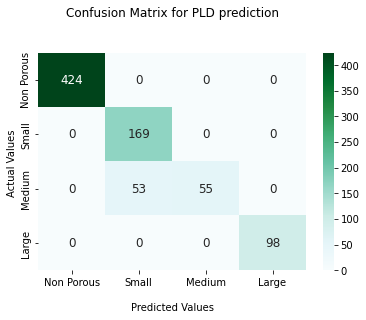

In [23]:
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))
    

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


cf_matrix = confusion_matrix(train_subjects,node_predictions)
print(cf_matrix)

cf_matrix1 = pd.DataFrame(cf_matrix,  index=["Non Porous","Small","Medium","Large"], columns=["Non Porous","Small","Medium","Large"])
ax = sns.heatmap(cf_matrix1, annot=True, cmap='BuGn',fmt='g',annot_kws={"size": 12})

ax.set_title('Confusion Matrix for PLD prediction\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');



In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [ ]:
emb = embedding_model.predict(all_mapper)
emb.shape

(799, 32)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

In [ ]:
X = emb
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

In [ ]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_subjects.index)
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_subjects.index)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored

NameError: ignored

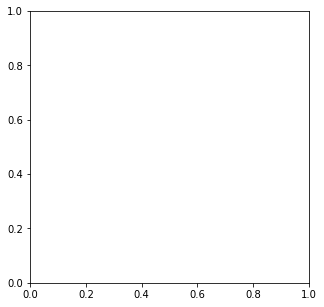

In [ ]:
alpha = 0.8

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for MOFSocialNetX".format(transform.__name__)
)
plt.show()

In [ ]:
for nid in train_subjects.index:
    Gnx.nodes[nid]["isTrain"] = True

for nid in test_subjects.index:
    Gnx.nodes[nid]["isTrain"] = False

In [ ]:
for nid in Gnx.nodes():
    Gnx.nodes[nid]["isCorrect"] = (
        Gnx.nodes[nid]["subject"] == Gnx.nodes[nid]["PREDICTED_subject"]
    )

KeyError: ignored

In [ ]:
pred_fname = "pred_n={}.graphml".format(num_samples)
nx.write_graphml(Gnx, os.path.join(dataset.data_directory, pred_fname))

In [1]:
pip install stellargraph


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 7.6 MB/s 
